# Phase 01: Data Cleaning & Normalization

#### Libraries

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

#### Loading the data and examines its structure

In [92]:
# Load the dataset
df = pd.read_csv('../data/raw/Spam_SMS.csv')  #TODO: ASK IF SHOULD HAVE A FUNCTION FOR FETCH DATA
df.head()

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [93]:
# print information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Class    5574 non-null   object
 1   Message  5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Based on the information, this DataFrame consists of <mark> 5,574 entities</mark> and contains <mark> no missing data.</mark>

In [94]:
df.describe()

,Class,Message
count,5574,5574
unique,2,5159
top,ham,"Sorry, I'll call later"
freq,4827,30


#### Check and handle missing values, duplicates and data types

In [95]:
# duplication
def check_duplicate_massages(dataframe):
    duplicates = dataframe[dataframe.duplicated(subset=['Message'], keep=False)]
    print(f"Number of duplicated messages: {len(duplicates)}")
    print("Example of duplicated messages: \n", duplicates.head(10))
    return duplicates


def check_missing_values(dataframe):
    missing_values = []
    for column in dataframe.columns:
        if dataframe[column].isnull().any():
            missing_values.append({
                column: dataframe[column].isnull().sum()
            })
    if missing_values:
        print(f"Number of missing values: {missing_values}")
    else:
        print(f"No missing values")


def check_data_types(dataframe):
    print(f"data types: {dataframe.dtypes}")


check_duplicate_massages(df)
check_missing_values(df)
check_data_types(df)

Number of duplicated messages: 705
Example of duplicated messages: 
    Class                                            Message
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...
7    ham  As per your request 'Melle Melle (Oru Minnamin...
8   spam  WINNER!! As a valued network customer you have...
9   spam  Had your mobile 11 months or more? U R entitle...
11  spam  SIX chances to win CASH! From 100 to 20,000 po...
12  spam  URGENT! You have won a 1 week FREE membership ...
45   ham                   No calls..messages..missed calls
56  spam  Congrats! 1 year special cinema pass for 2 is ...
62   ham                          Its a part of checking IQ
65  spam  As a valued customer, I am pleased to advise y...
No missing values
data types: Class      object
Message    object
dtype: object


Out of the 5,574 data samples, 4,827 are classified as ham.<mark> also Some messages are duplicate</mark>, and in total there are 5,159 unique messages. The message "Sorry, I'll call later" is the most frequent one, appearing 30 times.
Here, duplicate messages have been separated along with their classes. If identical messages have the same class, one instance can be kept and the rest removed in order to prevent model overfitting. However, if identical messages have different classes, they must be carefully examined to determine how they should be handled.


In [99]:
#This function keep first duplicate and throw away the rests
def handle_duplicate_messages(dataframe):
    dataframe = dataframe.drop_duplicates(subset=['Message'], keep='first')
    return dataframe


df = handle_duplicate_messages(df)

#### Data distribution

The distribution of messages class: Class
ham     4518
spam     641
Name: count, dtype: int64


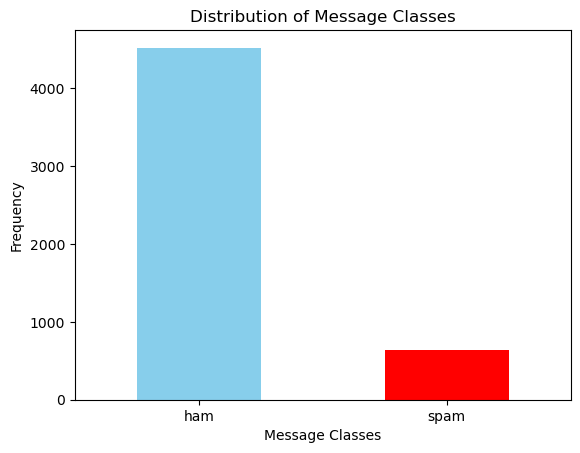

In [97]:
label_distribution = df['Class'].value_counts()
label_distribution.plot(kind='bar', color=['skyblue', 'red'])
plt.title('Distribution of Message Classes')
plt.xlabel('Message Classes')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
print(f"The distribution of messages class: {label_distribution}")  #TODO : make it look better
plt.show()

The distribution is highly <mark> imbalanced </mark> , with ham dominating the dataset (with 86.6% of instances). This is common in real-world spam detection scenarios, where legitimate messages far outnumber spam.
This means The data shows a clear <mark> skew </mark> , which might reflect real-world email traffic patterns but could lead to poor model performance on the minority class (spam) without adjustments.



#### Implement text normalization

In [98]:
def text_normalization(dataframe):
    dataframe['Message'] = dataframe['Message'].apply(lambda x: x.strip())
    dataframe['Message'] = dataframe['Message'].apply(lambda x: x.lower())
    dataframe['Message'] = dataframe['Message'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))
    return dataframe


# observed that most of the spams are include special characters so decided to add a feature named No_Special_characters
def count_special_characters(dataframe):
    dataframe['No_Special_characters'] = dataframe['Message'].apply(
        lambda x: pd.Series(re.findall(r'[^a-zA-Z\s\.\,\']', x)).unique().size)
    return dataframe


def encode_labels(dataframe):
    labels = dataframe['Class'].map({'ham': 0, 'spam': 1})
    dataframe.insert(loc=0, column='label', value=labels)
    dataframe.drop(columns=['Class'], inplace=True)
    return dataframe